# NFTs, NMF and Noise - A Dive Into Image Processing

**Candidates**: 10002, 10051 and 10132

Large sets of data is something we encounter often in life. Whether it is photo albums or other memorabilia, we often hold onto large amounts of data that mean something to us. The extreme case of this is the phenomenon known as 'hoarding'. Here, the victims have great struggle with letting go of certain items that are of high sentimental value to them. This often leads to the piling up of old newspapers, clothes, et cetera, which in extreme cases may drastically affect the victim's quality of life.

In a similar sense, we often want to analyze or use large amounts of data, but just like in the hoarder's case, this amount can easily become overwhelming and impossible to work with. A way to solve this problem, is therefore to find patterns in the data, allowing us to reduce the size of the data, while still retaining the (most essential) information.

More formally, this process of minimizing the amount of data is known as 'dimensionality reduction'. One way to do this, is by using matrices to represent our data, and using what is known as a 'Non-negative matrix factorization' (NMF). Here, we factorize a matrix $A$ into two new matrices, $W$ and $H$, such that 

$$A=WH$$

These matrices have dimensions: $A$: $m \times n$, $W$: $m \times d$ and $H$: $d \times n$. All elements of all matrices are non-negative, hence the name. Furthermore, our aim is that the total number of elements in our factorization will be smaller than the number of elements in $A$, meaning

$$m\cdot d + n \cdot d < m \cdot n \qquad \Rightarrow \qquad d < \frac{mn}{m+n}$$  

In this project, we aim to use our knowledge of linear algebra to manipulate and work with these matrices, and apply it to digital image processing. Our dataset consists of 10000 images of so-called 'cryptopunks', and we wish to find patterns in these images to compress the size of the set. We will also look into noise reduction in these images. 

In [2]:
from google.colab import drive

drive.mount('/gdrive')

#!unzip vitber/imgs.zip -d "/gdrive/My Drive"

!ln -s "/gdrive/My Drive/imgs" "/content/imgs"

Mounted at /gdrive


In [1]:
"""
Installation of various python libraries/extensions
"""
import numpy as np        
%pip install --upgrade pip
!sudo apt-get update -y
!apt-get install ffmpeg libsm6 libxext6  -y
%pip install opencv-python               # Required to import cv2
import cv2

import os
import time

#Various packages related to plotting. Installs latex and amsmath for displaying matrices.
from matplotlib import pyplot as plt, animation 
from matplotlib.gridspec import GridSpec
!sudo apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super
%pip install latex
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16, 'figure.titlesize': 18, 'animation.html': 'jshtml', 'text.usetex': True, 'figure.dpi': 600})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
from IPython.display import HTML, Image

import cupy as cp                        #Library that essentially enables us to run numpy on GPU

#Creates directories for plots
from pathlib import Path
directories = ["Animations", "Cryptopunks (without noise)", "Cryptopunks with noise", "Matrices/Matrix A1", "Matrices/Matrix A2", "Matrices/Matrix A3", "Matrices/Matrix A4"]
for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)

     |████████████████████████████████| 2.1 MB 4.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [82.3 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu18

Before we dive into the problems of dimensionality reduction for images, we first acquaint ourselves with the NMF-algorithm. Here, we aim to understand more about what conditions our matrices should be subjected to, in order to make sure that the algorithm functions as expected. 

We first need to ensure that our algorithm only produces non-negative matrices $H_k$ and $W_k$. Here we will assume that $A$ is non-negative, as well as $W$ and $H$ being initialized as positive matrices. The algorithm used consists of several iterations, in which the following two calculations are performed.

$$(H_{k+1})_{ij}=(H_k)_{ij}\cdot \frac{(W_k^T A)_{ij}}{(W_k^TW_kH_k)_{ij}}$$

$$(W_{k+1})_{ij}=(W_k)_{ij}\cdot \frac{(AH_{k+1}^T)_{ij}}{(W_kH_{k+1}H_{k+1}^T)_{ij}}$$

We first note that the matrix multiplaction between two non-negative matrices will result in a new non-negative matrix, as all entries in the product matrix will consist of sums of non-negative scalars.

Our algorithm also consists of element-wise multiplication and division. Again, this will result in a non-negative matrix, as we will also only be multiplying/dividing non-negative scalars.

As we start with positive matrices, we will therefore, by induction, only generate non-negative matrices $H_k$ and $W_k$.

We also note that $H_{k+1}=H_k$, if the matrix  $W^TA \oslash W^TWH $ only consists of ones. Here, our iteration reduces to $(H_{k+1})_{ij}=(H_{k})_{ij}\cdot1$. We can also notice that this happens when $WH=A$. By multiplying both sides with $W^T$, we get $W^TA = W^TWH $. Dividing the left-hand side by the right hand-side element-wise, we get a matrix of ones. This holds as long as $W^TA$ is positive. Essentially, this means that our iteration stops being updated once we have a perfect reconstruction $A=WH$.

If we try to initialize our $H$ and $W$ as matrices only containing zeroes, we encounter some problems. First of all we would divide by zero, which would break the algorithm. Furthermore, if we solve the problmem of dividing by zero, for example by adding a small number $\delta$ to the denominator, we would still only get a new matrix of zeroes because we multiply with 0.

In [3]:
def NMF(A, d, delta = 1e-9, maxiter = 1000, seed = 0, dtype=np.float32):
    """
    This function aims to calculate the NMF of our input matrix A. This is done by initializing two matrices W and H
    with random entries between 0 and 1, and then using the algorithm that was previously presented to calulate the 
    NMF.
    Utilizes the cupy library, to make the algorithm compute faster.

    input:
        A: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
        dtype: np.float64 or np.float32, precision used in calculations.
               np.float64 should be used for smaller matrices, 
               while np.float32 should be sufficient for larger data sets
    output:
        W: (m,d) array
        H: (d,n) array
        error: float
    """

    #Code to ensure that we might get the same random initialization, given that we have the same seed as input
    if seed != 0:
        cp.random.seed(seed)

    A_c = cp.asarray(A, dtype=dtype) #Makes a copy of A to a cupy array with given precision
    m, n = A_c.shape

    #We initialize W and H with random numbers from the interval [0, 1]
    W = cp.random.uniform(size = (m,d), dtype=dtype)
    H = cp.random.uniform(size = (d,n), dtype=dtype)

    #We now scale these initial matrices by the factor sqrt(mean(A)/d), as this might 
    W *= np.sqrt(cp.mean(A_c)/d)
    H *= np.sqrt(cp.mean(A_c)/d)

    error_array = np.zeros((maxiter), dtype=dtype)
    #The calculation itself
    for k in range(maxiter):
        H = cp.multiply(H, cp.divide(W.T @ A_c, W.T @ (W @ H) + delta))
        W = cp.multiply(W, cp.divide(A_c @ H.T, W @ (H @ H.T) + delta))
        
        #Calculates the deviance between our calculated factorization, and the matrix A, with the help of the
        #Frobenius norm
        error = cp.linalg.norm(A_c-W @ H, "fro")
        error_array[k] = error

    return cp.asnumpy(W), cp.asnumpy(H), error_array


After having implemented the algorithm, we now want to test it by applying it to certain matrices. These matrices are 

$$A_1 = \begin{bmatrix} 1 & 0 \\0 & 1 \end{bmatrix}$$

$$A_2 = \begin{bmatrix} 1 & 2 \\1 & 1 \\ 1 & 2 \end{bmatrix}$$



In [4]:
def print_matrices(matrices, labels, caption=None, filename=None, figsize=(15,3)):
    """
    Displays 2d-arrays in markdown latex text.

    input:
        matrices: (N,m,n) array consisting of N 2d-arrays
        labels: array of labels, adds for instace "A=" in front of the matrices
        caption: string with additional text, plotted in a separate box
        filename: string
        figsize: tuple
    """
    #Initializes a figure with subplots (2 if caption is given, 1 if not)
    fig = plt.figure(figsize=figsize)
    if caption is not None:
        gs = GridSpec(1, 2, width_ratios=[6,1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
    else:
        gs = GridSpec(1, 1)
        ax1 = fig.add_subplot(gs[0])

    #Creates a string with the matrices in latex format
    matrix_string = ""
    for N in range(len(matrices)):
        matrix_string += labels[N] + r"$\begin{bmatrix}"
        m, n = np.shape(matrices[N])

        for i in range(m):
            for j in range(n):
                matrix_string += rf"{matrices[N][i][j]:.5f}"
                if j!=n-1:
                    matrix_string += r" & "
            if i!=m-1:
                matrix_string += r"\\"
        matrix_string += r"\end{bmatrix}$"
        if N != len(matrices)-1:
            matrix_string += r"\quad"

    #Plots the matrices and caption in separate boxes
    ax1.text(0.02, 0.4, matrix_string, size=20, bbox=dict(boxstyle="round, pad=0.5",fc=(1,0.97,0.95)))
    ax1.axis("off")
    if caption is not None:
        ax2.text(-2, 0.35, caption, size=20, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95,1,1)))
        ax2.axis("off")
    plt.tight_layout()
    if filename is not None:  #Saves plot to file
        plt.savefig(filename)
    plt.show()

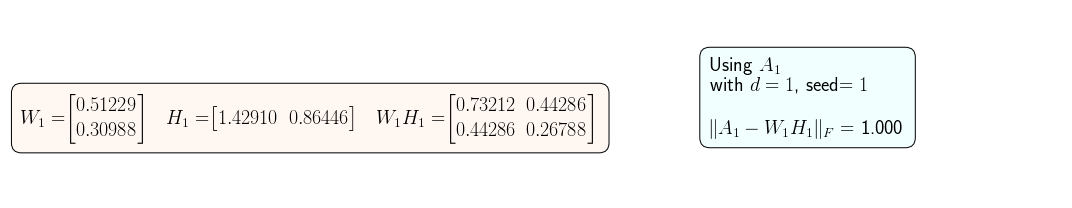

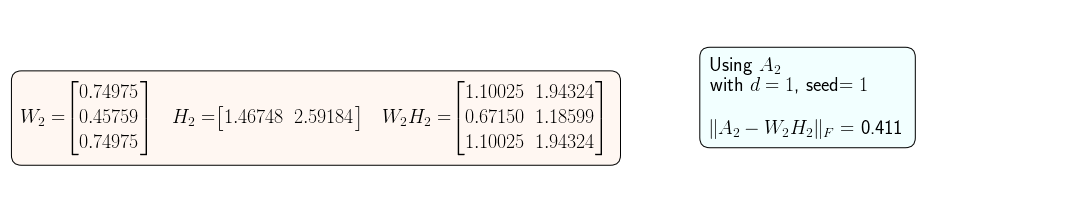

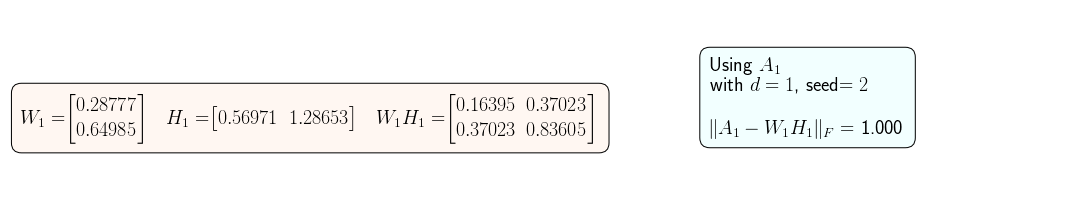

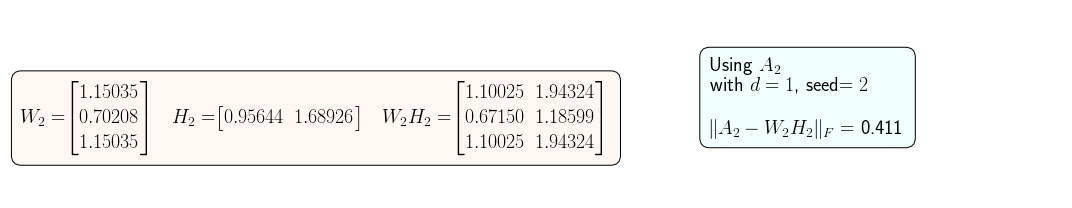

In [5]:
A1 = np.array([[1,0],
               [0,1]])

A2 = np.array([[1,2],
               [1,1],
               [1,2]])

for seed in [1,2]:
    N=1
    for A in [A1, A2]:
        W, H, error = NMF(A, 1, 1e-9, 1000, seed, np.float64) 
        print_matrices([W, H, W @ H], 
                       [rf"$W_{N}=$", rf"$H_{N}=$", rf"$W_{N} H_{N}=$"],
                        rf"Using $A_{N}$"+f"\n"+rf"with $d=1$, seed$={seed}$" + f"\n\n" + rf"$\|A_{N}-W_{N}H_{N}\|_F=$ {error[-1]:.3f}",
                        filename=f"Matrices/Matrix A{N}/Matrix A{N} with seed {seed}.png")
        N+=1

We notice that none of the new matrices are able to perfectly reconstuct the original matrix with $d=1$. However, for our second matrix, the product $W_2H_2$ seems to converge to the same matrix for both seeds, whereas for the first matrix, we get different reconstructions every time. This implies that the NMF reconstruction might be unique for some matrices $A$, but not for all. 

Furthermore, we observe that the error of both matrices seem independent of the initializations. We will now look more into the error for different seeds, to ensure it is not just a one off.

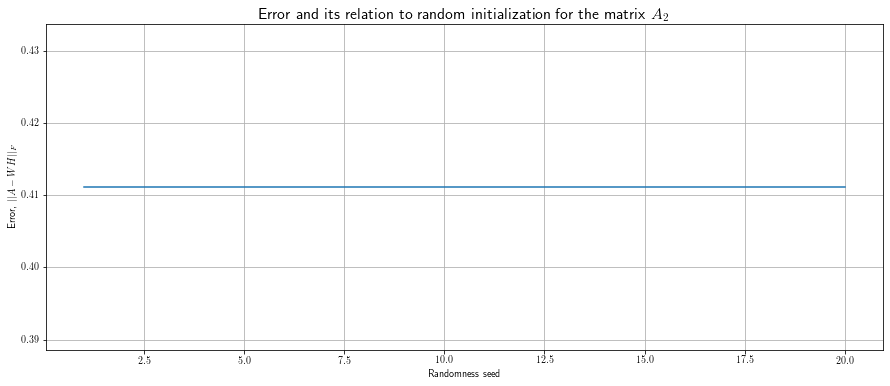

In [35]:
seed_array = np.linspace(1,20,20, dtype = 'i2')
error_array = np.zeros_like(seed_array, dtype=np.float64)

for i in range(len(seed_array)):
    error= NMF(A2, 1, 1e-9, 1000, seed_array[i], np.float64)[-1][-1] #Global error, after all iterations
    error_array[i] = error

plt.figure(figsize=(15,6))
plt.title(r"Error and its relation to random initialization for the matrix $A_2$")
plt.plot(seed_array, error_array)
plt.xlabel("Randomness seed")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.grid()
plt.savefig(f"Matrices/Matrix A2/Correlation between error and seed.png")
plt.show()

As is clear from the plot above, the error is independent of the seed used for the initialization. This implies that for these matrices, it is hard to come across initializations that do not converge toward the best possible solution. Having examined the relation between error and seed, we now move along to perhaps more interesting matters: the relation between error and $d$. We will now increase to $d=2$, where we expect a smaller error, as $W$ and $H$ will be able to hold more information.

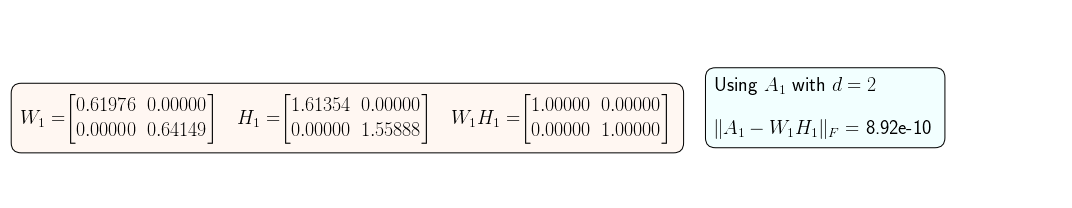

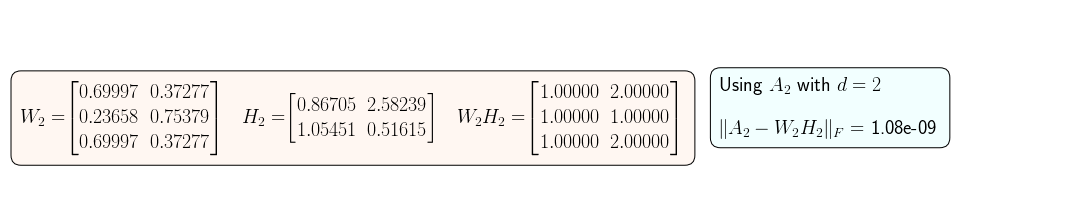

In [7]:
N=1
for A in [A1, A2]:
    W, H, error = NMF(A, 2, 1e-9, 1000, 1, np.float64) 
    print_matrices([W, H, W @ H], 
                   [rf"$W_{N}=$", rf"$H_{N}=$", rf"$W_{N} H_{N}=$"],
                    rf"Using $A_{N}$ with $d=2$" + f"\n\n" + rf"$\|A_{N}-W_{N}H_{N}\|_F=$ {error[-1]:.3}",
                   filename=f"Matrices/Matrix A{N}/Matrix A{N} with d=2.png")
    N+=1

As we see above, the matrices $W_1H_1$ and $W_2H_2$ are almost identical to $A_1$ and $A_2$, which is a significant improvement from $d=1$. Therefore, our error is also drastically reduced, especially for $A_1$. Still, it is not clear why this should be the case, and which properties of the matrix $A$ it is that determine the optimal $d$. A possible candidate such a property, is the rank of the matrix. By rank, we mean "the maximum number of its linearly independent column vectors (or row vectors)" (Rózsa 2007). 

To investigate further, we will now calculate the ranks of the matrices

$$A_3 =\begin {bmatrix} 2 & 1 & 1 \\ 2& 1 & 1 \\ 1 & 1 & 2\end {bmatrix}$$

$$A_4 =\begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end {bmatrix}$$

to look at the correlation between error and the value of $d$. We will be using 'singular value decomposition' (SVD) to find the rank, where we can simply count the number of non-zero singular values of $A$.

With SVD, we want to decompose $A$ such that $A$=$U\Sigma V^*$. 
We then have $$ \operatorname{rank(A)} = \operatorname{rank(U\Sigma V^*)} $$.
We also have that both $U$ and $V^*$ are invertible matrices, and therefore also full-rank (Wikipedia 2022).

It can be shown that both right and left multiplication by a full-rank matrix does not change the rank of the original matrix (Taboga 2021). Since square invertible matrices are full-rank, we get 

$$ \operatorname{rank(A)} = \operatorname{rank(U\Sigma V^*)} = \operatorname{rank(\Sigma)}$$

Since the only non-zero values of $\Sigma$ are along its main diagonal, its rank must be equal to the number of non-zero elements in $\Sigma$. These elements are the non-zero singular values of $A$.

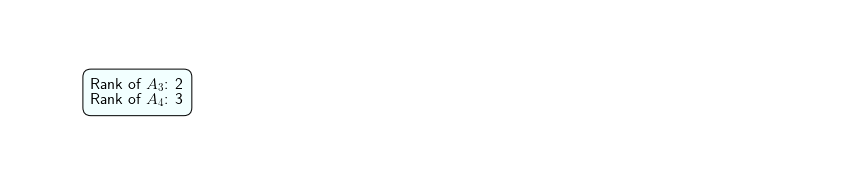

In [36]:
A3 = np.array([[2,1,1],
               [2,1,1],
               [1,1,2]])

A4 = np.array([[2,1,0],
               [1,2,3],
               [0,3,3]])

def get_rank(A):
    """
    Finds rank of 2d-array A, using SVD
    
    input:
        A: 2d-array
    output:
        rank: int, rank of 2d-array
    """
    #Uses Singular Value Decomposition
    u, s, vh = np.linalg.svd(A)

    #Counts the non-zero singular values of A, found in s (1E-12 as threshold) 
    rank = np.count_nonzero(s > 1E-12)

    return rank


plt.figure(figsize=(15,3))
plt.text(0.1, 0.4, f"Rank of " +rf"$A_3$: {get_rank(A3)}"+ f"\nRank of "+rf"$A_4$: {get_rank(A4)}", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95,1,1)))
plt.axis("off")
plt.savefig("Matrices/Rank of A3 and A4.png")
plt.show()

Having found the ranks, we now aim to investigate how this quantity may aid us in the process of choosing a suitable $d$ for a precise reconstruction. We will do this by plotting the error, as defined earlier, as a function of number of iterations, for different $d$ for both matrices. By doing so, we might discover a relationship between a matrix's rank and the optimal choice of $d$. 

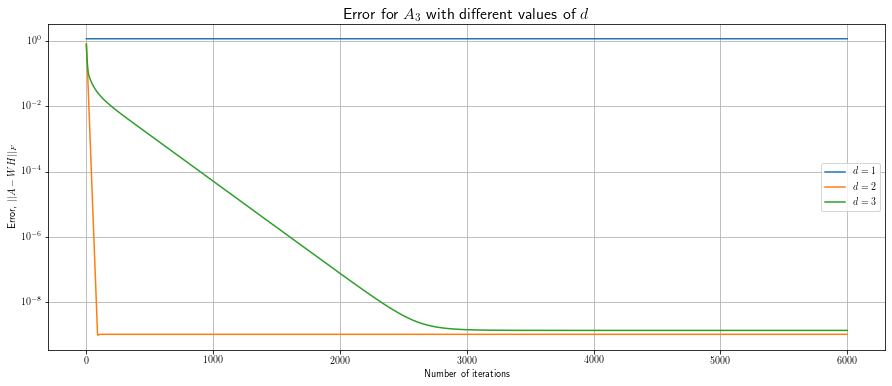

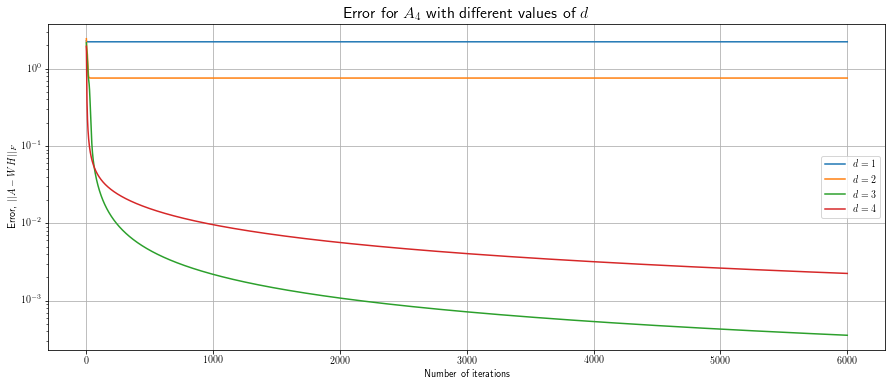

In [37]:
max_iterations = 6000
error_A3_array = np.zeros((max_iterations,3), dtype=np.float64)
error_A4_array = np.zeros((max_iterations,4), dtype=np.float64)
d_array = np.array([1,2,3,4])
num_iterations = np.linspace(1, max_iterations, max_iterations, dtype='i2')

for i in range(len(d_array)):
    error_A4_array[:,i] = NMF(A4, d_array[i], 1e-9, max_iterations, 2022, np.float64)[-1]
    if i!=3: 
        error_A3_array[:,i] = NMF(A3, d_array[i], 1e-9, max_iterations, 2022, np.float64)[-1] 

plt.figure(figsize=(15,6))
plt.title(r"Error for $A_3$ with different values of $d$")
plt.plot(num_iterations, error_A3_array)
plt.xlabel("Number of iterations")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.semilogy()
plt.grid()
plt.legend([r'$d=1$',r'$d=2$',r'$d=3$'], loc=7)
plt.savefig("Matrices/Matrix A3/Error for A3 with different values of d.png")
plt.show()

plt.figure(figsize=(15,6))
plt.title(r"Error for $A_4$ with different values of $d$")
plt.plot(num_iterations, error_A4_array)
plt.xlabel("Number of iterations")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.semilogy()
plt.grid()
plt.legend([r'$d=1$',r'$d=2$',r'$d=3$', r'$d=4$'], loc=7)
plt.savefig("Matrices/Matrix A4/Error for A4 with different values of d.png")
plt.show()

From the plots above we can conclude that using $d < \operatorname{rank(A)}$ does not give a good reconstuction of the original matrix $A$. This seems logical, as the rank may be thought of a measure of how many rows of $A$ contain essential information. If one then tries to reconstruct this while ignoring this essential information, it seems plausible that the reconstructions also become worse. Furthermore, we notice that increasing the value of $d$, above the value of the matrix's rank, increases the error. However, this is not a general rule and depends on the initializations of $W$ and $H$.

Therefore, it seems that choosing a $d$ as close to $\operatorname{rank(A)}$ as possible, reduces the error greatly $d$ and gives fast convergence. However, it should be taken into account that a too large $d$ will increase the amount of data, which will be a problem for larger data sets.

The equation $||A-W_{k+1}H{k+1}||_F \leq ||A-W_{k}H{k}||_F$ is satisfied in all our plots, meaning that the error decreases toward a minimum. For a larger number of iterations, we often get equality, meaning that we have reached this minimum.

Having learnt a bit more about the algorithm, we now move forward to what will be the focus of the remainder of the project, pictures. Here, we will use a set of data consisting of 10 000 CyberPunk NFTs, and sample $N$ of these, so that we will have different images to work with. Each image consists of $24 \times 24$ pixels, each with RGB values and an opacity channel. This leaves us with $24\cdot24\cdot3=1728$ values for one RGB image. This is a substantial amount of data, which we will attempt to compress.

Below is an example of 64 such images.

In [10]:
"""Code handed out together with the project text"""

def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images

np.random.seed(2) #random
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces500 = faces[:,:,:,choices]

# Check that the shape is correct
#print(faces500.shape)

In [11]:
"""Code handed out together with the project text"""

# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, title = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set title of plot
    if title is not None:
        fig.suptitle(title, size = 20, y=1)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


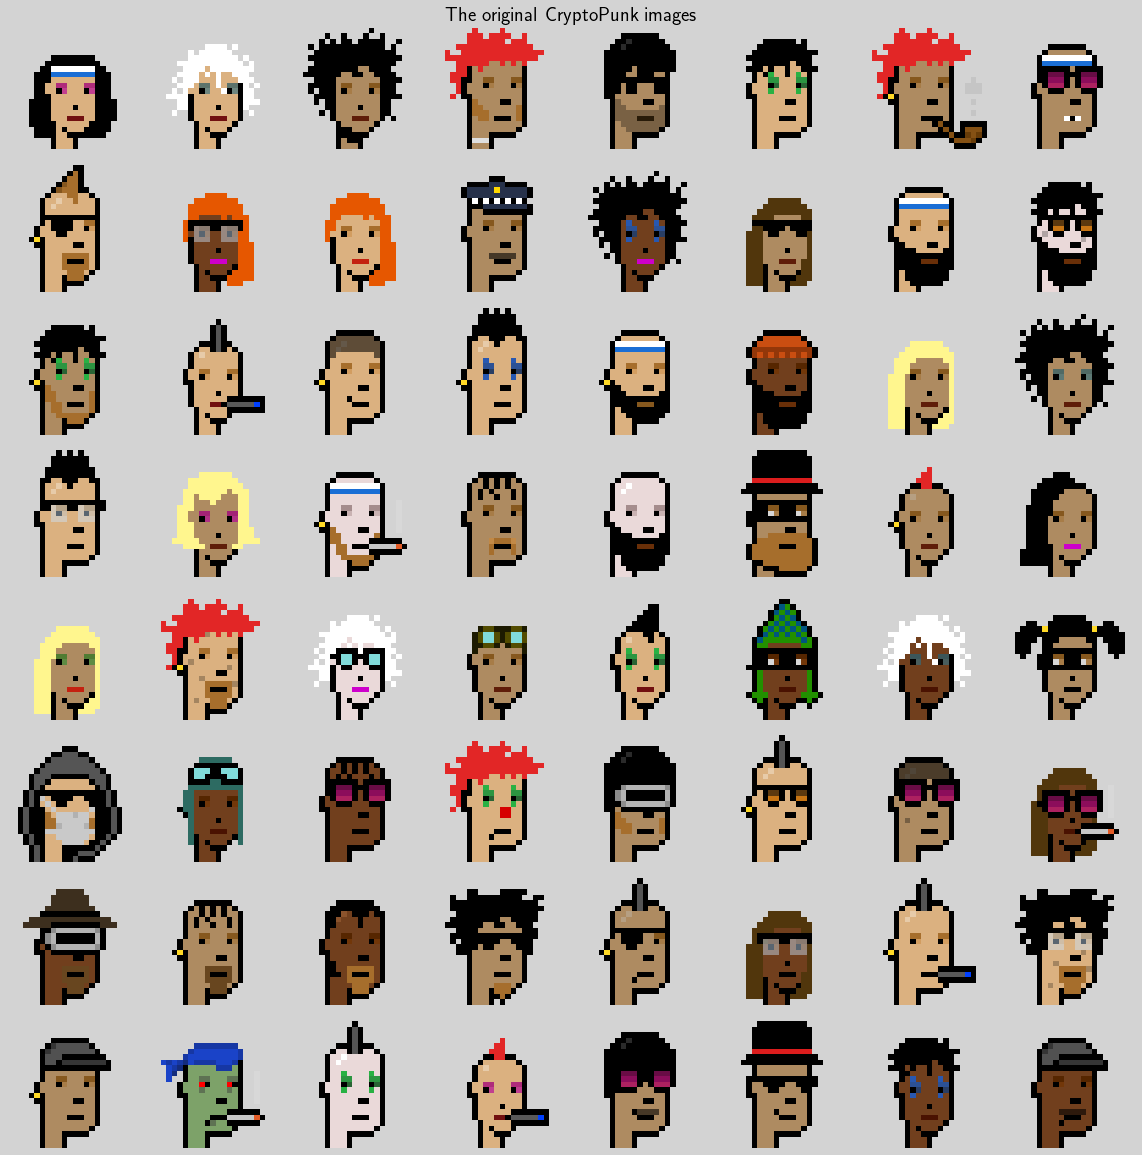

In [12]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces500, 8, filename="Cryptopunks (without noise)/Punks.png", title="The original CryptoPunk images")

From these images, it is evident that there exists features that are present in several of the images. Examples of this is cigarettes, hairstyles and face shapes. Our aim is now to be able to detect such features from our $N$ images, and use these features to store the images in a more compact way.  So, instead of saving each image as 1728 values, we can store it as a linear combination of certain features, for instance a cigarette, an earring or a pair of sunglasses.

To do this, we first try to acquaint ourselves a bit more with the data set. Firstly, we calculate an "average picture" in which the values in each channel for a pixel is the average of the values in each channel in this pixel in every image. This means that for three pictures, each with R-values of 0.2, 0.3 and 0.4 for the pixel in the upper left corner, will produce an average picture, with a R-value of 0.3 for the pixel in the upper left corner. This will work analogously for other pixels and channels. By doing this, we might uncover structures in our dataset, which might in turn make it clear what information is redundant.  

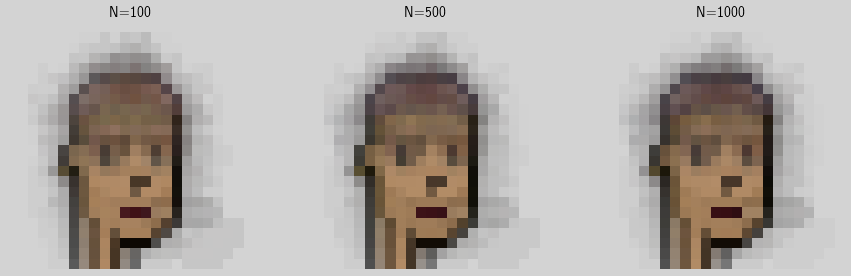

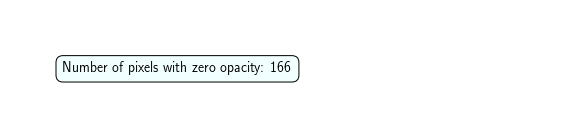

In [38]:
N1=100
choices = np.random.choice(faces.shape[-1], N1, replace = False)
faces100 = faces[:,:,:,choices]
average_face100 = np.mean(faces100, axis=-1)

plt.figure(figsize=(15,6))
plt.subplot(131)
plt.title(f"N={N1}", fontsize=14)
plt.gcf().set_facecolor("lightgray")
plt.imshow(average_face100)
plt.axis("off")
#plt.savefig("average_face.png")

#Code for the matrix containing 500 matrices
N2=500
average_face500 = np.mean(faces500, axis=-1)

plt.subplot(132)
plt.title(f"N={N2}", fontsize=14)
plt.imshow(average_face500)
plt.axis("off")

N3=1000
choices = np.random.choice(faces.shape[-1],N3, replace = False)
faces1000 = faces[:,:,:,choices]
average_face1000 = np.mean(faces1000, axis=-1)

plt.subplot(133)
plt.title(f"N={N3}", fontsize=14)
plt.imshow(average_face1000)
plt.axis("off")
plt.savefig("Cryptopunks (without noise)/Average face.png")
plt.show()

#Finds number of pixels with no opacity
opacity_average_face500 = average_face500[:,:,3]
zero_opacity_pixels = np.count_nonzero(opacity_average_face500 == 0)

plt.figure(figsize = (10,2))
plt.text(0.1, 0.4, f"Number of pixels with zero opacity: {zero_opacity_pixels}", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.savefig("Cryptopunks (without noise)/Error and sample size.png")
plt.show()

Above, you can see three images, with every image being the average image as previously described, using a set of $N$ pictures. Just looking at these images, it might be difficult to see any clear differences between the samples. We therefore now want to compare these images to eachother, and examine the distance between them. To do this, we will again need norms, but also to reshape the matrices we now have. Given that our images contain $24 \times 24$ pixels, each with $3$ color channels and a opacity channel, our image-matrix has the dimensions $24\times24\times4$. 

To work with the norms we have used previously, we therefore want to reshape our matrix, and this will also come in handy later, when finding NMFs of the images. The idea here is that the function should take in a $24\times24\times4\times N$ matrix, and return the reshaped array, in the form $1728 \times N$. We choose to leave the opacity channel out of the reshaped vector, but we still return it so that it can be added onto the images later.

In [14]:
def reshape_images(faces):
    """
    Splits the data into opacity and rgb arrays, and reshapes the faces array ...
    input:
        faces: (24,24,4,N) array containing images
    output:
        faces_opacity: (24,24,N) array containing opacity channel of images 
        faces_rgb: (24,24,3,N) array containing rgb channel of images
        faces_reshaped: (24·24·3, N) array, containing faces_rgb, reshaped 
    """
    N = np.shape(faces)[-1]
    faces = np.where(faces<1,faces,1) #Clips pixel values >1 to 1

    """Code handed out together with the project text"""

    # Split the images into opacity and rgb channels
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape

    # Clever reshape "trick". This is the matrix we will apply the NMF to
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
    
    return faces_opacity, faces_rgb, faces_reshaped

opacity, RGB, faces_reshaped = reshape_images(faces500)

Here, we have chosen our measure of error as the distance between a given average image and the average image composed of 500 images, that is $E_N =||A_{avg, 500} - A_{avg, N}||_{F}$, to see if $N=500$ is an acceptable sample size. We then find the ratio between the errors for samples containing 100 and 1000 pictures by calculating $E_{100} / E_{1000}$.

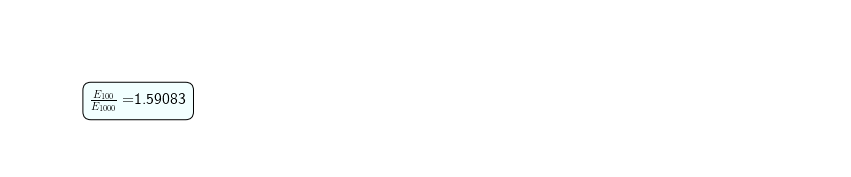

In [39]:
#Code to look at the difference/error between the different pictures 

A = np.zeros((24,24,4,1))
A[:,:,:,0]=average_face500
average_face500_reshaped = reshape_images(A)[-1]

A = np.zeros((24,24,4,1))
A[:,:,:,0]=average_face100
average_face100_reshaped = reshape_images(A)[-1]

A = np.zeros((24,24,4,1))
A[:,:,:,0]=average_face1000
average_face1000_reshaped = reshape_images(A)[-1]

ratio = np.linalg.norm(average_face500_reshaped-average_face100_reshaped, "fro")/np.linalg.norm(average_face500_reshaped-average_face1000_reshaped, "fro")

plt.figure(figsize=(15,3))
plt.text(0.1, 0.4, r"$\frac {E_{100}}{E_{1000}} = $" + f"{ratio:.5f}", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.savefig("Cryptopunks (without noise)/Error and sample size.png")
plt.show()

This means that the distance between the average images of samples of 100 and 500 pictures is greater than that of samples of 500 and 1000. This implies that the accuracy increases, but at a slower rate, for larger sample sizes. Therefore, we expect that a sample size of 500 images, should yield plausible results. 

To investigate this further, we can also examine the rank of the matrix that contains the images. This quantity can be thought of as something that describes how many distinct features that are found in our sample by the algorithm. We expect that the rank increases with the sample size, as more features might be included into the sample. 

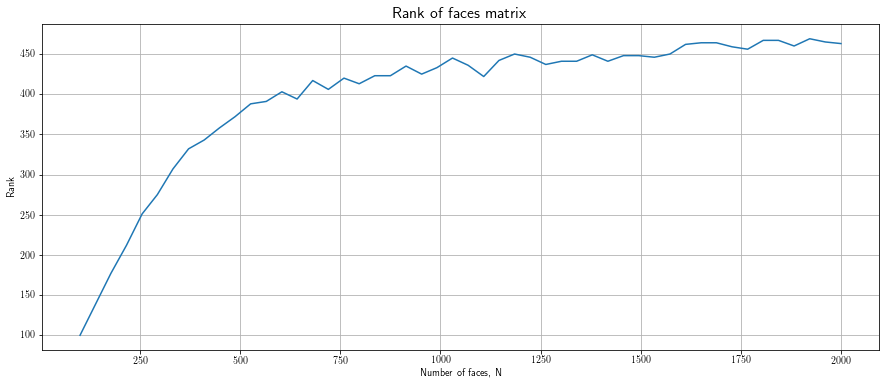

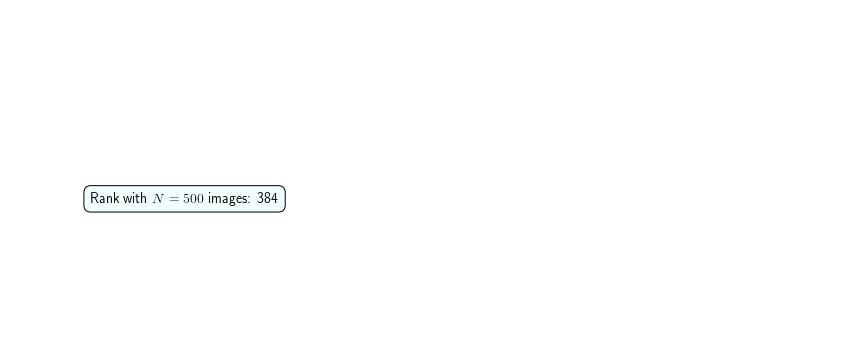

In [40]:
# Code to find the rank of matrices containing different amount of faces
n = 50
rank_array = np.zeros(n)
N_array = np.linspace(100, 2000, n, dtype='i2')

for i in range(n):
    choices = np.random.choice(faces.shape[-1],N_array[i], replace = False)
    facesi = faces[:,:,:,choices]
    facesi_reshaped = reshape_images(facesi)[-1]
    rank_array[i] = get_rank(facesi_reshaped)

plt.figure(figsize=(15,6))
plt.title("Rank of faces matrix")
plt.plot(N_array, rank_array)
plt.xlabel("Number of faces, N")
plt.ylabel("Rank")
plt.grid()
plt.savefig("Cryptopunks (without noise)/Rank of faces matrix.png")
plt.show()

plt.figure(figsize=(15,3))
plt.text(0.1, 0.4, rf"Rank with $N=500$ images: {get_rank(faces_reshaped)}", size=14, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.savefig("Cryptopunks (without noise)/Rank of cryptopunks dataset, N=500.png")
plt.show()

Here, we see that there is a general trend where a larger sample size introduces more distinct features.
For lower values of $N$, we have a somewhat linear relationship between sample size and rank, indicating that number of unique features increases steadily by increasing our sample size. This makes instinctively sense, as we are unlikely to get very similar pictures with a small sample size.

We want a sample size big enough, where we no longer see this drastic increase in unique features by increasing the sample size. For the larger values of $N$, we see that the graph flattens out, indicating that we have reached this threshold. We have therefore concluded that setting $N=500$ is sufficient, from our graph above and from investigating the "average face" earlier. This gives a good compromise between having a representative sample and our limited computational resources.

In order to successfully reduce the amount of data, we will then need to use $d < \frac{1728\cdot500}{1728+500}\approx388$. This means that if we for instance choose a $d=64$, we will reduce the amount of data to approximately $64/388\cdot100 \%  = 16.5 \% $ of its original size. 

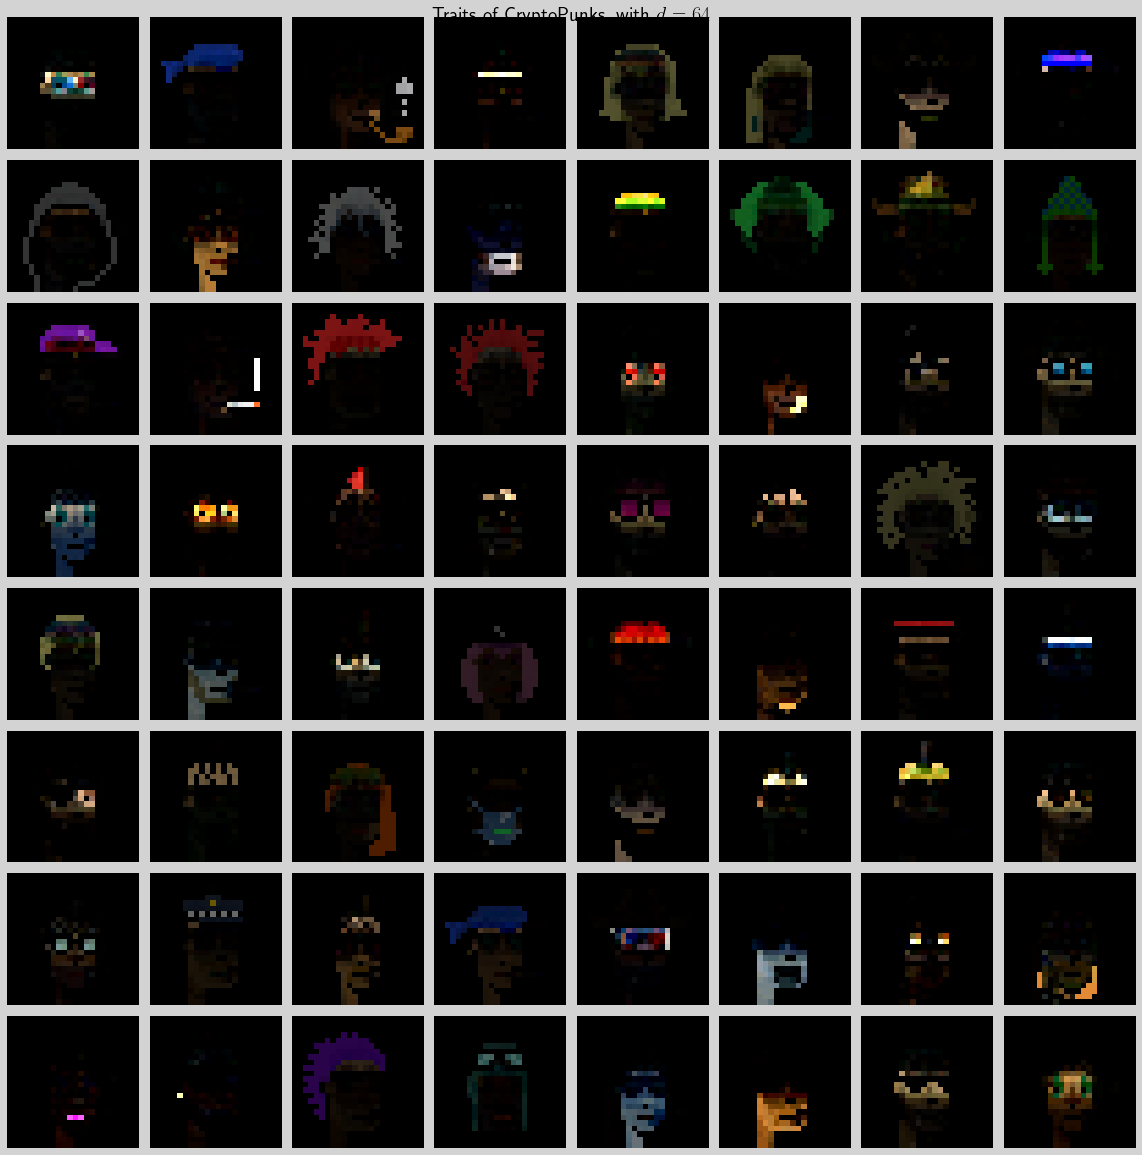

In [17]:
#Finding the NMF of 500 pictures
d=64
W, H, error_estimate = NMF(faces_reshaped, 64, 1e-9, 1000, 1)

A = W @ H

H_noiseless = np.copy(H) #Variable used to store the weights for the features in the reconstructions

A = np.where(A < 1, A, 1) #Clips all values >1 to 1
W = np.where(W < 1, W, 1)

noiseless_features = np.zeros((24,24,3,d))
for i in range(d):
    noiseless_features[:,:,:,i]= np.reshape(W[:,i], (24, 24, 3))

plotimgs(noiseless_features, 8, filename="Cryptopunks (without noise)/NMF traits.png", title = r"Traits of CryptoPunks, with $d=64$")

Above, we have plotted the columns of $W$ as separate pictures, as we can interpret these columns as basis vectors of each column in our matrix $A$. We can write each column in $A$ as

$$a_j = Wh_j = w_1h_{1j}+w_2h_{2j}+...+w_dh_{dj} \qquad i \in [1, d], \quad j \in [1, n]$$

where  $a_j$ is a column in $A$, $w_i$ is a column in $W$ and $h_{ij}$ is an element in column $j$ of $H$.

Each column in $A$ is therefore a linear combination consisting of the columns of $W$ with the elements of a column in $H$ as weights.

In our project, the images above can therefore be interpreted as reoccurring features in our sample, and $H$ can be interpreted as the importance of these features in each image.

We will now use this information to reconstruct the face images we plotted earlier. To do this, we multiply together $W$ and $H$, and add the original opacity, such that a column in the product-matrix represents a reconstructed image.

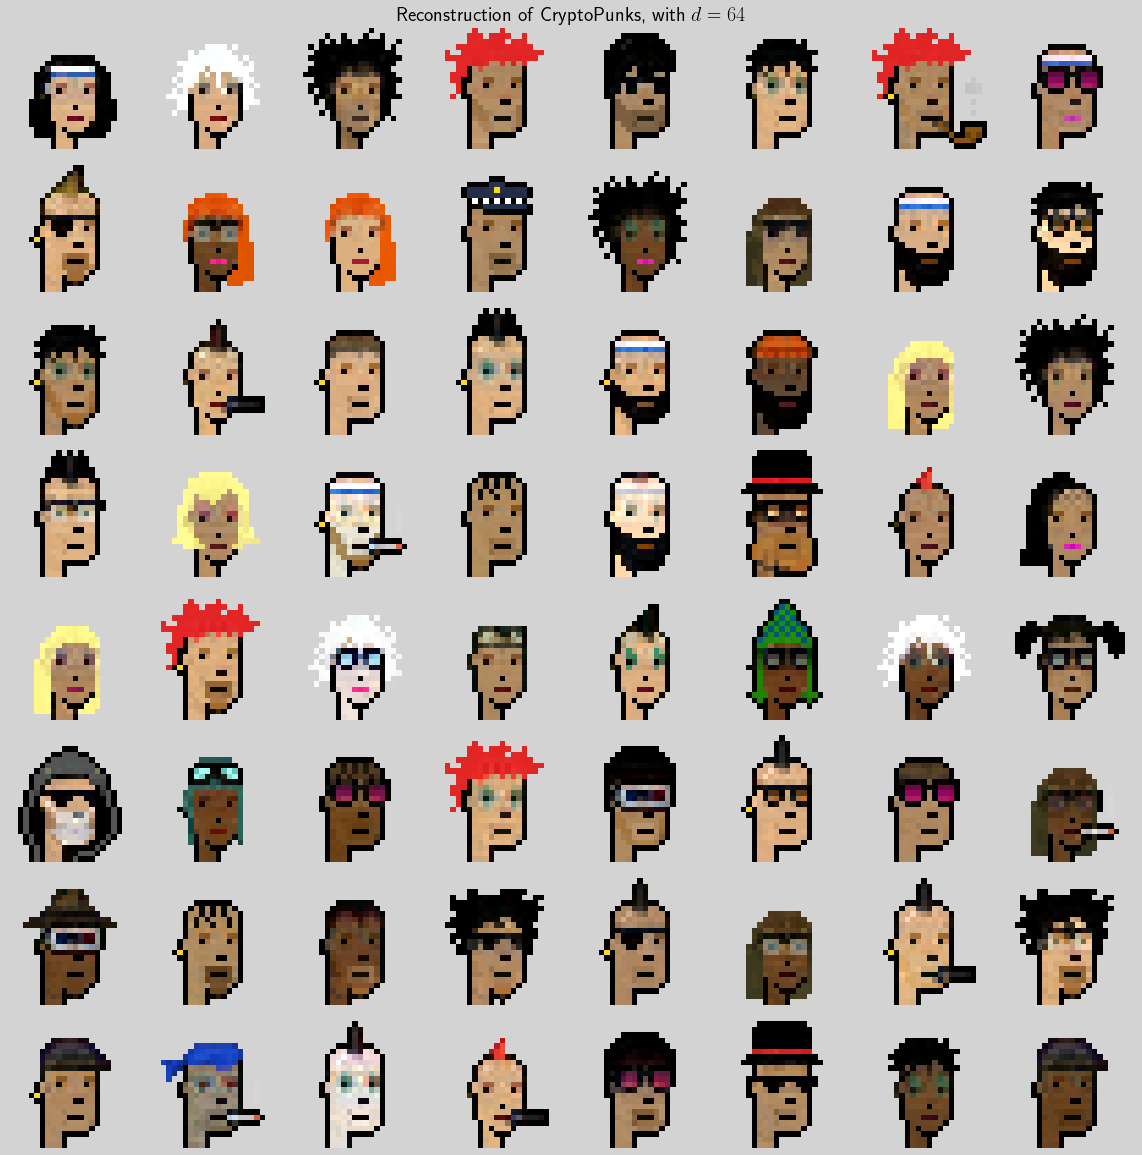

In [18]:
reconstructed_faces_with_opacity = np.zeros(faces500.shape)
reconstructed_faces_with_opacity[:,:,:3,:] = A.reshape(RGB.shape)
reconstructed_faces_with_opacity[:,:,3,:] = opacity

plotimgs(reconstructed_faces_with_opacity, 8, filename="Cryptopunks (without noise)/NMF reconstruction.png", title = r"Reconstruction of CryptoPunks, with $d=64$")

Above, we have plotted our 64 reconstructed images, based on the 64 images we displayed earlier. It is evident that some features are preserved well under the reconstruction, for instance the pipes or cigarettes. Other features, such as skin colour and eye-makeup are a bit more weird-looking. This might for example be because very pale skin is underrepresented in our sample, which leaves pale punks visibly altered from their original appearance. However, it is difficult to quantify these differences from looking at the pictures alone, and which features that are underrepresented might vary from sample to sample. We therefore turn to the Frobenius norm once again, to see how the choice of $d$ affects the reconstructions in a given sample.  

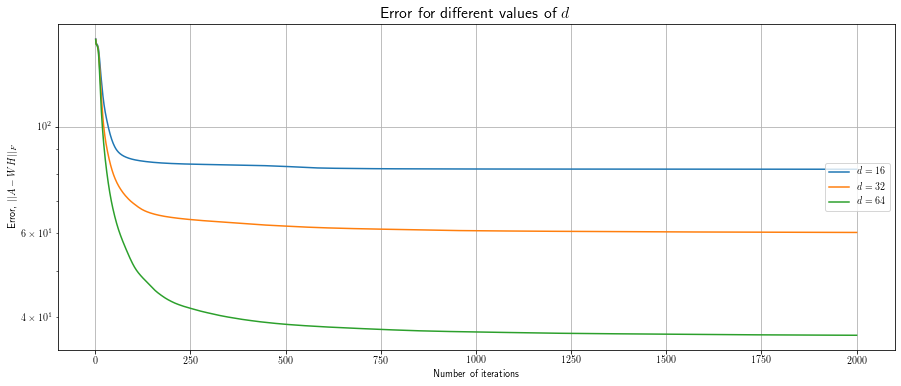

In [41]:
d_array = np.array([16,32,64])
max_iterations = 2000
error_array = np.zeros((max_iterations, len(d_array)), dtype = np.float64)
iterations_array = np.linspace(1, max_iterations, max_iterations, dtype = 'i2')

for i in range(len(d_array)):
    error = NMF(faces_reshaped, d_array[i], 1e-9, max_iterations, 1)[-1]
    error_array[:,i] = error

plt.figure(figsize=(15,6))
plt.title(r"Error for different values of $d$")
plt.plot(iterations_array, error_array)
plt.xlabel("Number of iterations")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.semilogy()
plt.grid()
plt.legend([rf'$d={d_array[0]}$',rf'$d={d_array[1]}$',rf'$d={d_array[2]}$'], loc=7)
plt.savefig("Cryptopunks (without noise)/Error for different values of d.png")
plt.show()

From the plot above, it is clear that the error decreases for an increasing number of iterations. This means that our algorithm never gets further away from the solution, which is preferable. Furthermore, it is clear that after roughly 500 iterations the error for $d=16$ and $d=32$ are pretty much constant, while the error for $d=64$ becomes constant after about 1000 iterations. This implies that our algortihm has converged to the best possible solution for the given $d$, and we also notice that the algorithm converges relatively fast. In future tasks, we will mostly be using 1000 iterations for $d=64$ based on these results.

From this, it is evident that the Frobenius norm is a useful tool for studying general trends with our method. Another way to do this, which might be more comprehensible, is animating the reconstructions for different $d$. This differs from the previous way of presenting reconstructions, as we now only present the reconstructions of one image, but do so for different $d$.

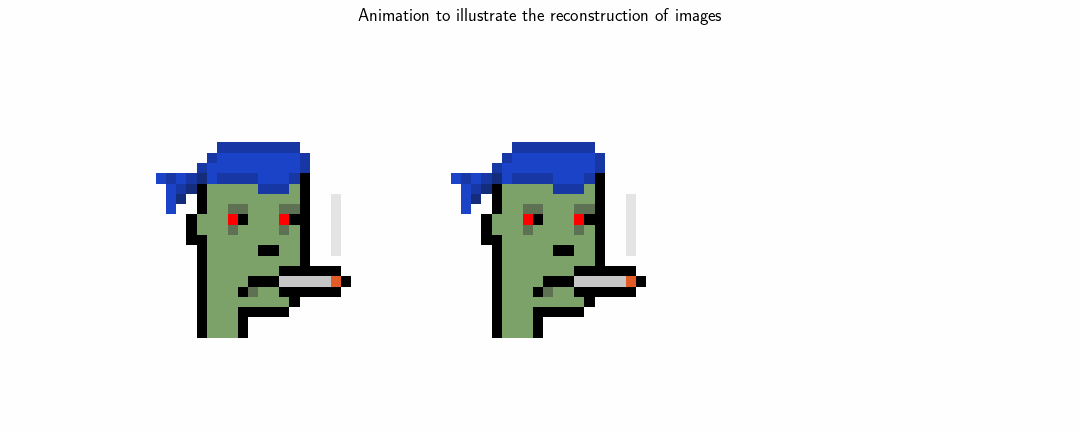

In [20]:
ds = np.array([0, 4, 8, 16, 32, 64, 128, 256])
im = 57 #The index of the image we want to display

N_plots = len(ds)

reconstruction_array = np.zeros((N_plots, 24, 24, 4))
reconstruction_array[0] = faces500[:, :, :,im]

for i in range(N_plots-1):
    W, H, errors = NMF(faces_reshaped, ds[i+1])
    A = W @ H[:,im]

    face_with_opacity = np.zeros((24,24,4))
    face_with_opacity[:,:,:3] = A.reshape((24,24,3))
    face_with_opacity[:,:,3] = opacity[:,:,im]
    reconstruction_array[i+1] = face_with_opacity

reconstruction_array = np.where(reconstruction_array < 1, reconstruction_array, 1)

#Creates animation
fig, ax = plt.subplots(figsize=(15,6), ncols = 3)
fig.suptitle("Animation to illustrate the reconstruction of images")
def animate(i):
    ax[0].imshow(reconstruction_array[0])
    ax[0].axis("off")
    
    ax[1].imshow(reconstruction_array[i])
    ax[1].axis("off")
    
    if i!=0:
        text_string = f"Original image to the left.\nReconstructed image to the right.\n"+rf"Using $d = $ {ds[i]}"
        ax[2].text(0, 0.4, text_string, size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
    ax[2].axis("off")

anim = animation.FuncAnimation(fig, animate, interval=1500, frames=N_plots)
anim.save('Animations/Reconstruction with different values of d.gif', writer='pillow')
#Displays animation
with open('Animations/Reconstruction with different values of d.gif','rb') as file:
    display(Image(file.read()))
plt.close()

The animation above shows that reconstuctions with low values of $d$ are quite inaccurate. With $d=4$ for instance we keep the same head shape, but that is about it. The colours are far off and features like the hat and his green skin colour are completely absent. Along the way, one might also observe features such as a yellow earring and blue and red eyes, which are not present in the original image. When we increase the value of $d$ the colours gradually become more alike with the initial image and we also gain more of the initial features. Visually, one can therefore see that for $d = 256$, we get quite qualitatively satisfying reconstructions, while still actually compressing the data. 

We can also quantify these trends by plotting the Frobenius norm after $1000$ iterations for different values of $d$. Based on the animation above, we expect lower errors with increasing $d$.


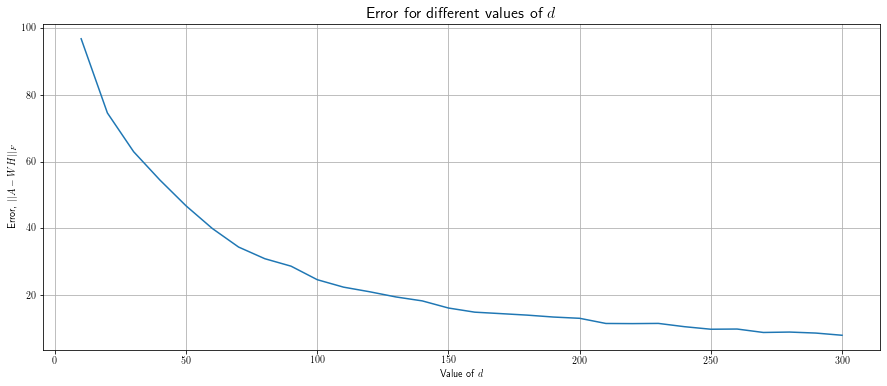

In [32]:
d_array = np.linspace(10, 300, 30, dtype='i2')
max_iterations = 1000
error_array = np.zeros(len(d_array))

for i in range(len(d_array)):
    error = NMF(faces_reshaped, d_array[i], 1e-9, max_iterations, 1)[-1][-1] #error at last iteration
    error_array[i] = error

plt.figure(figsize=(15,6))
plt.title(r"Error for different values of $d$")
plt.plot(d_array, error_array)
plt.xlabel(r"Value of $d$")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.grid()
plt.savefig("Cryptopunks (without noise)/Error for different values of d.png")
plt.show()

From the plot above we see that the error is strictly decreasing with increasing $d$ values. This means that a higher $d$ value will create more precise reconstuctions. We also notice that the error decreases rapidly in the beginning, before flattening out for larger values. This might be because when we include more features, by increasing d, we will eventually come across features that are less prevalent in the sample, and therefore might be of great importance for one image, but not for many others. We therefore gain little adittional information about the sample as a whole, by increasing $d$ further for these large $d$ ,which leads to a a smaller decrease in the error.

Having to choose which $d$ to use resembles how fishers have to choose a fishing net to use. There exists many different forms of such nets, each with different strengths. These nets work similarily to huge hand nets when they are dragged through the water, and they might be characterized by their mesh size. This is a measure of how large the holes of the net are. With a large mesh size large fish might be more easily caught, but the smaller ones are let through. A disadvantage of this might be that the fisher does not catch enough fish. On the other hand, a small mesh size will catch almost everything that enters the net. Then the fisher would have to spend time to sort out the junk, in order to isolate what is actually desired. 

This analogy of the fisher's net represents a frequent problem in machine learning, finding the balance between under- and overfitting. Underfitting in the fisher's situation would mean that the mesh size is too large, so that more than what is desired of the fish and waste is able to leave the net. On the other hand, we have overfitting, which for the fisher would mean choosing a too low mesh size, so that too much fish and waste is included.

Up until now, a net with smaller and smaller holes has given us a higher degree of accuracy. This is mainly because we have not ecountered things in our dataset that are the equivalent of waste in the ocean, we have been fishing in a pond containing solely fish. However, as we now progress, we want to introduce more elements to our pond, to then observe if the general trend of using tighter and tighter holes yielding better results still holds, or if we find examples of over- and underfitting. 

To do this, we want to include waste in our pond, in the form of noise in our images. We have chosen to use a form of Gaussian noise. This means that for each image matrix, we add a random number between zero and one to all non-zero color channels. Doing this for only non-zero channels, might seem to be a bit out-of-sync with the random nature of noise, but we avoid some problems by doing so. One of these might be that black pixels remain black even after noise is added, which means that a punk's face shape is conserved, since the shape is normally made up of black pixels. Furthermore, we clip values greater than one to be one, so that it is still possible to plot the noisy images.   

In [22]:
"""Code handed out together with the project text"""

def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

Having implemented the algorithm above, we are able to apply noise to our images. Below is an animation to illustrate the visual effect of adding noise, for varying noise coefficients, $\sigma$. This coefficient is a number multiplied to each random number before it is added to a color channel, such that a $\sigma =0$ provides zero noise to the image, whilst an increasing $\sigma$ would provide more and more noise to the image. With a very high $\sigma$, all non-zero  color channels are 1, whilst the rest remain at 0, provided that no random numbers smaller than $1/\sigma$ are chosen. 

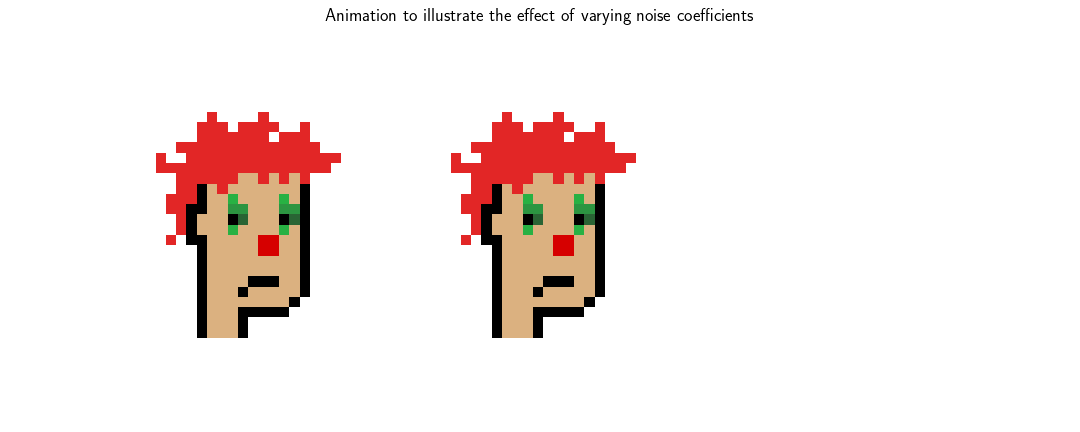

In [27]:
im = 43 #The index of the image we want to display

N_plots = 6 
sigma_array = np.linspace(0, 0.2, N_plots)

noisy_array = np.zeros((N_plots, 24, 24, 4))
noisy_array[0] = faces500[:, :, :,im]

for i in range(N_plots-1):
    noisy_face = add_noise(faces_reshaped[:,im], sigma_array[i+1])
    
    noisy_face_with_opacity = np.zeros((24,24,4))
    noisy_face_with_opacity[:,:,:3] = noisy_face.reshape((24,24,3))
    noisy_face_with_opacity[:,:,3] = opacity[:,:,im]
    noisy_array[i+1] = noisy_face_with_opacity

fig, ax = plt.subplots(figsize=(15,6), ncols = 3)
fig.suptitle("Animation to illustrate the effect of varying noise coefficients")
def animate(i):
    ax[0].imshow(noisy_array[0])
    ax[0].axis("off")

    ax[1].imshow(noisy_array[i])
    ax[1].axis("off")
    
    if i!=0:
        text_string =  f"Original image to the left.\nNoisy image to the right.\n" + rf"Using $\sigma = $ {sigma_array[i]:.3f}"
        ax[2].text(0, 0.4, text_string, size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
    ax[2].axis("off")
anim = animation.FuncAnimation(fig, animate, interval=1500, frames=N_plots)
anim.save('Animations/NoiseAnimation.gif', writer='pillow')
#Displays animation
with open('Animations/NoiseAnimation.gif','rb') as file:
    display(Image(file.read()))
plt.close()

From the animation above, it is clear that choosing a large noise coefficient renders almost unrecognizable noisy versions of the image. Therefore, we choose a $\sigma = 0.1$, as this seems to give noisy images, in which it is often possible to recognize the person through the noise. Firstly, we add noise to our sample, and then present the 64 first images in this sample below.

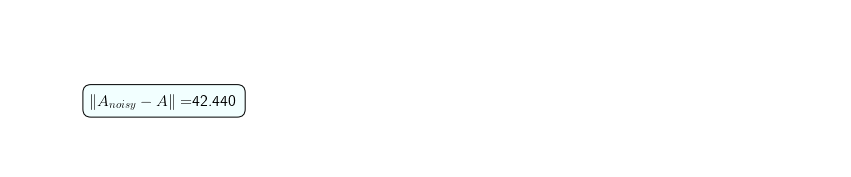

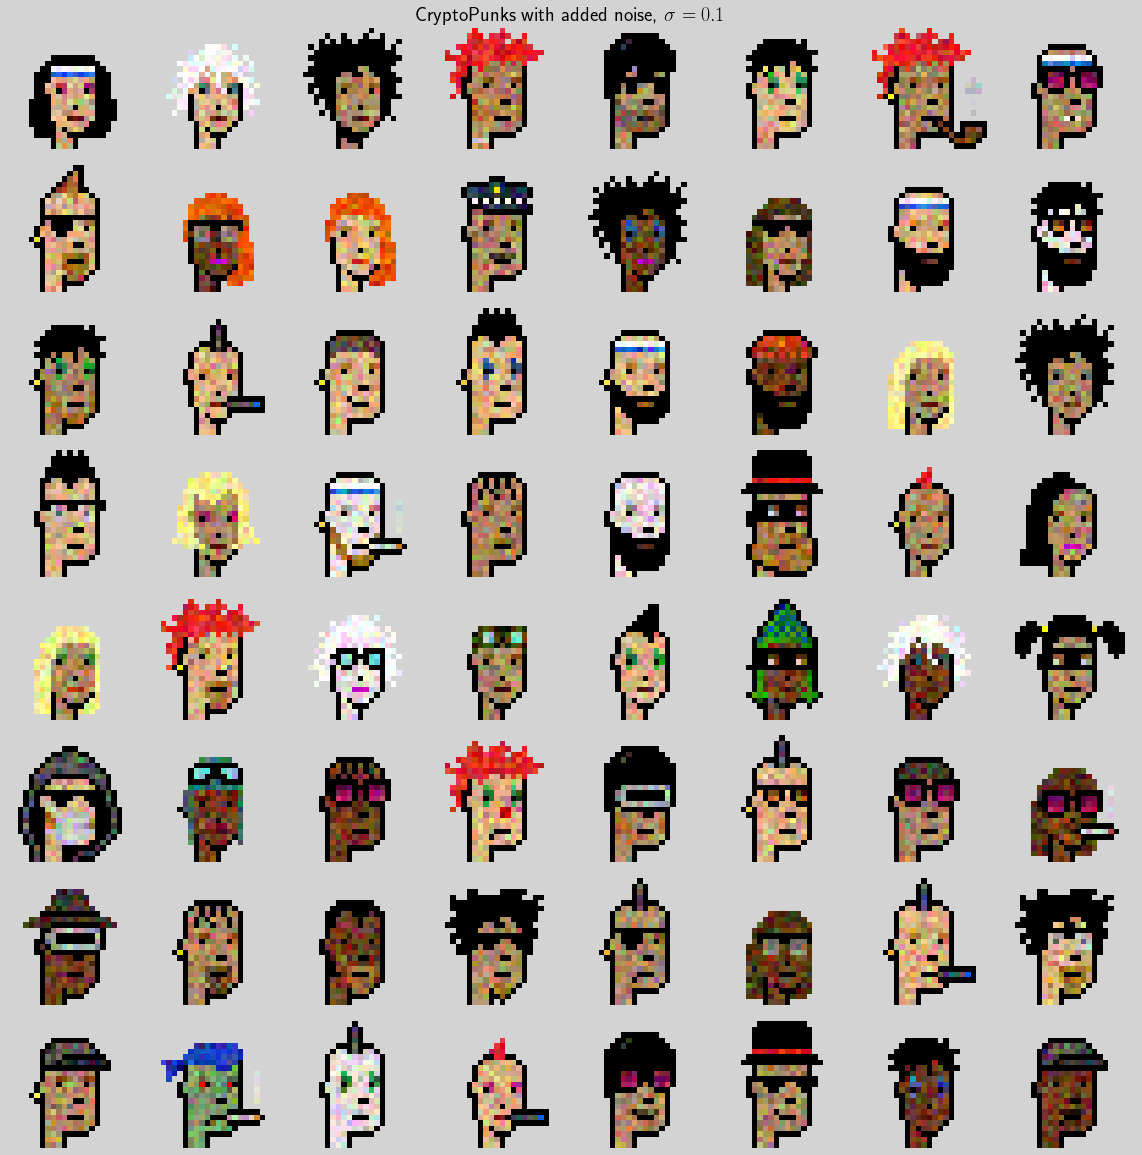

In [42]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)

plt.figure(figsize=(15,3))
plt.text(0.1, 0.4, r"$\|A_{noisy} - A\| =$" +f"{noise_residual:.3f}", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.savefig("Cryptopunks with noise/Error, noisy compared to original.png")
plt.show()

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces500.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(RGB.shape)
noisy_faces_with_opacity[:,:,3,:] = opacity
plotimgs(noisy_faces_with_opacity, 8, filename = "Cryptopunks with noise/Noisy punks.png", title = r"CryptoPunks with added noise, $\sigma=0.1$")

As for the earlier presented animation, we can see from the 64 plotted images that most punks are indeed visually recognizable, despite the added noise. We have previously encountered an error of about 40 for our reconstructed images, with $d = 64$. These images were good reconstructions of our punks in that they were recognizable, but there was often trouble with reconstructing things such as skin or eye color accurately. This is something that is also true for these noisy images, and using the Frobenius norm, one might therefore argue that our previous reconstructions and these noisy images are very similar. 

Given this similarity, we are curious to see how the reconstructions of these noisy images would turn out. 

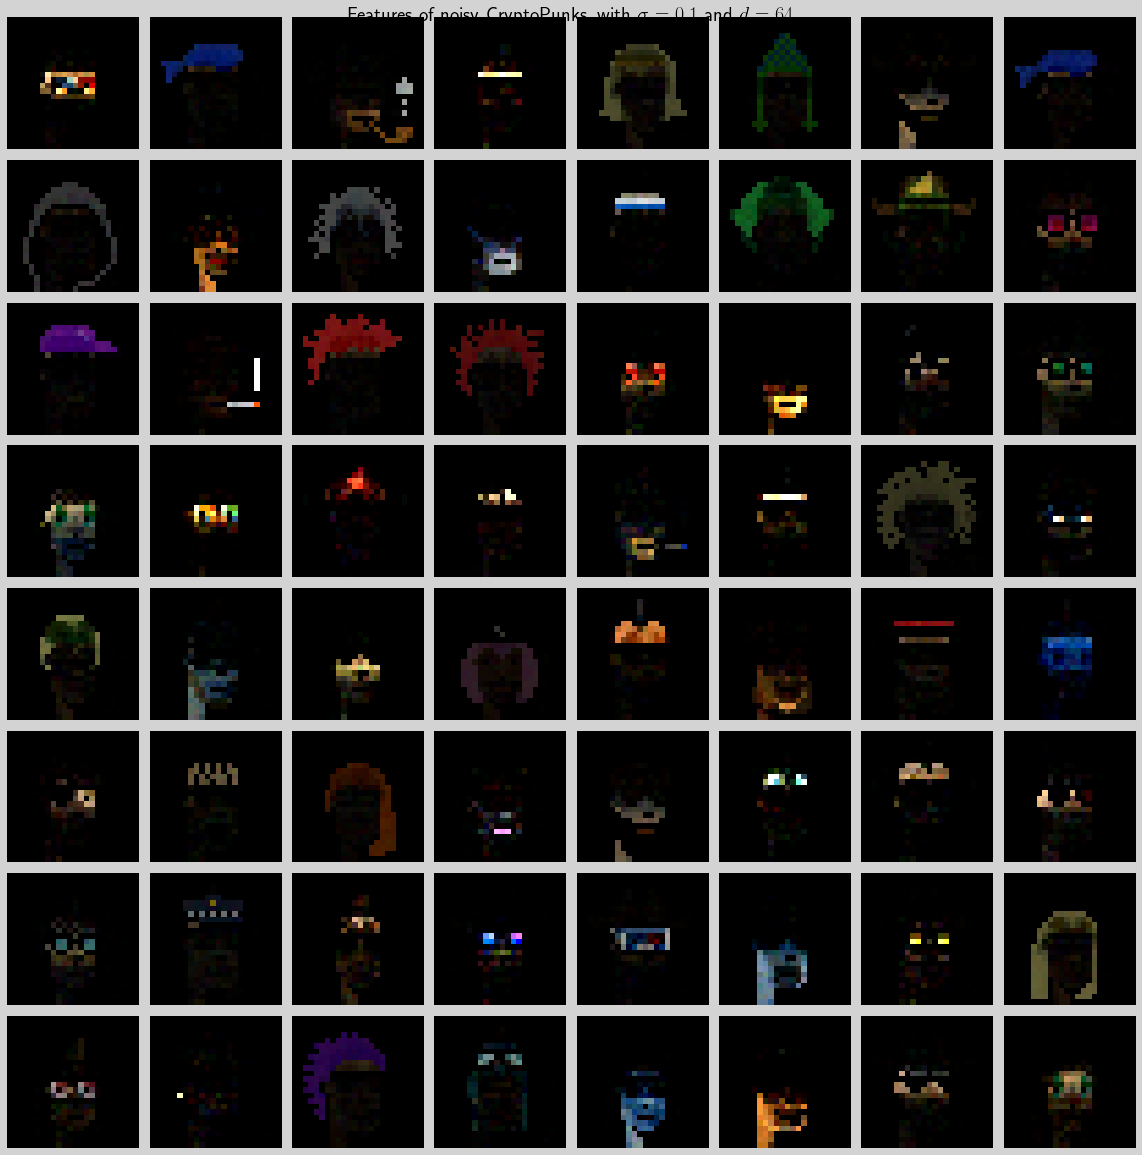

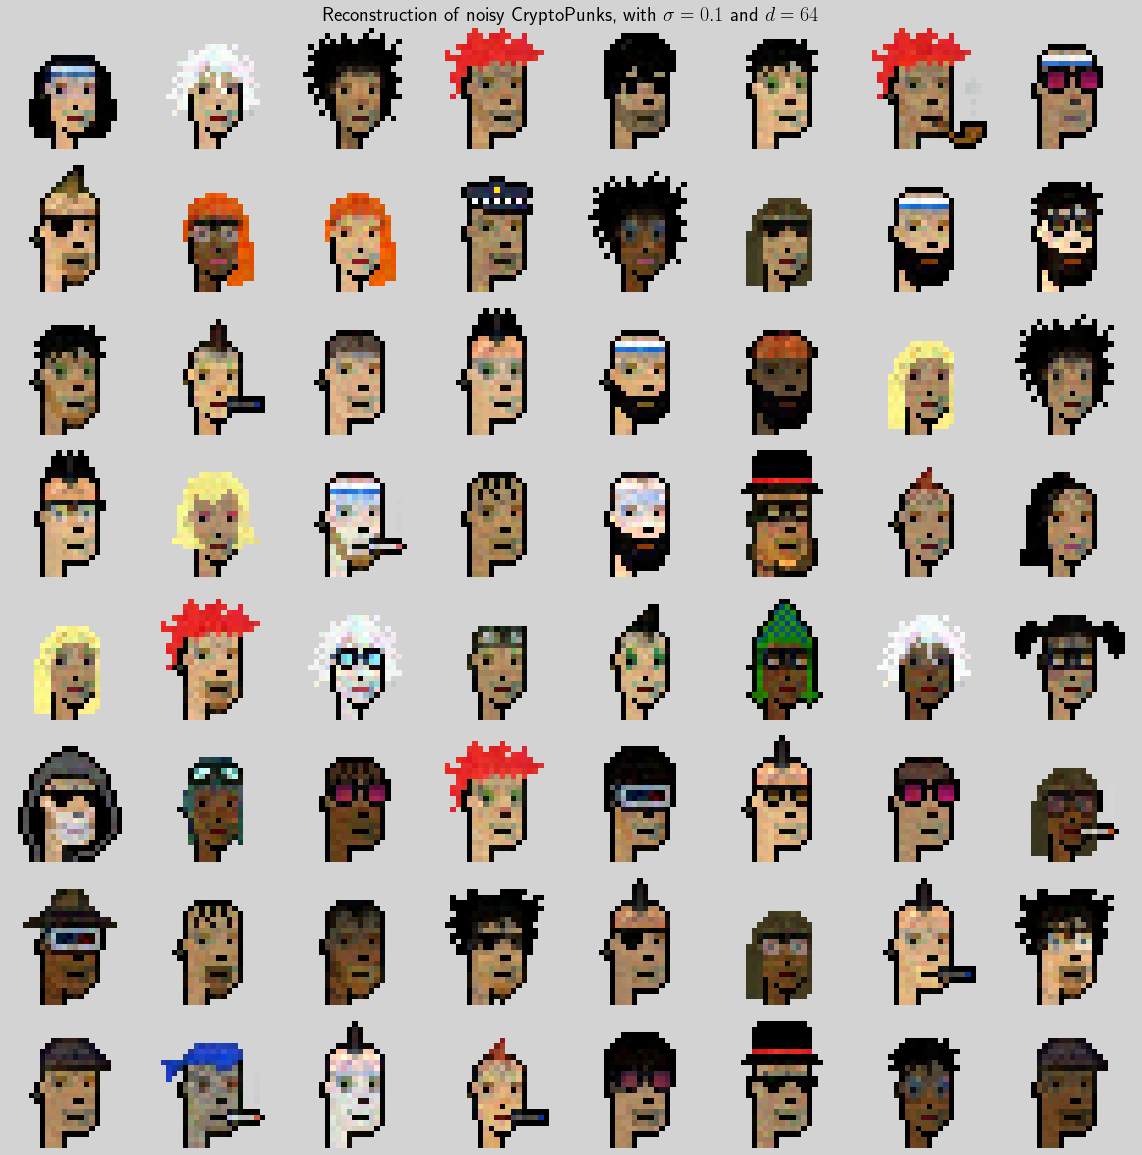

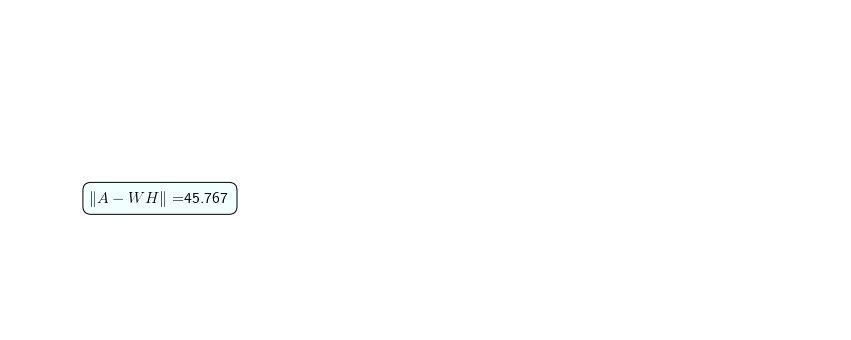

In [43]:
d=64

noisy_faces = add_noise(faces_reshaped)

W, H, error_estimate = NMF(noisy_faces, d, 1e-9, 1000, 1)
H_noisy = np.copy(H) #Variable used to store the weights for the features in the reconstructions
W = np.where(W < 1, W, 1) #Clips all values to 1

#Reshapes W
noisy_features = np.zeros((24,24,3,d))
for i in range(d):
    noisy_features[:,:,:,i]= np.reshape(W[:,i], (24, 24, 3))

plotimgs(noisy_features, 8, filename= "Cryptopunks with noise/NMF With noise traits.png", title = r"Features of noisy CryptoPunks, with $\sigma=0.1$ and $d=64$")

#Reconstruction
A = W @ H 
A = np.where(A < 1, A, 1) #Clips all the values to 1

#Adds opacity
faces_with_opacity = np.zeros(faces500.shape)
faces_with_opacity[:,:,:3,:] = A.reshape(RGB.shape)
faces_with_opacity[:,:,3,:] = opacity

plotimgs(faces_with_opacity, 8, filename="Cryptopunks with noise/NMF With noise reconstruction.png", title = r"Reconstruction of noisy CryptoPunks, with $\sigma=0.1$ and $d=64$")

noise_residual = np.linalg.norm(A - faces_reshaped, "fro") 
 
plt.figure(figsize=(15,6))
plt.text(0.1, 0.4, r"$\|A-WH\| =$" +f"{noise_residual:.3f}", size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
plt.axis("off")
plt.savefig("Cryptopunks with noise/Something.png")
plt.show()

We notice that the reconstructed images appear to have less noise than the original noisy images. This is because we have used a value for $d$ that is sufficiently low in order to neglect the noise, but still captures the most prominent features.

Furthermore, it turns out that the distance between the image matrices has increased after being through the NMF algorithm, even though they look visually improved. This implies that we as humans have somewhat different criteria, compared to the computer, when it comes to comparing images. Where humans look at the overall picture and the consistency of the color, of for instance the hair, the computer just goes through every pixel and calculates the difference using the Frobenius norm. Even though the Frobenius norm sometimes differs from our expectations, it is still a very useful tool.

When comparing the noisy features of $W$ to the ones without noise, we notice that the order is slightly shuffled. This is not a great surprise, as the solutions for $W$ are rarely unique. However, the overall shape of the features still look relatively alike, although the noisy features generally tend to contain more of the surroundings as well. This is also illustrated further in the animation below. 

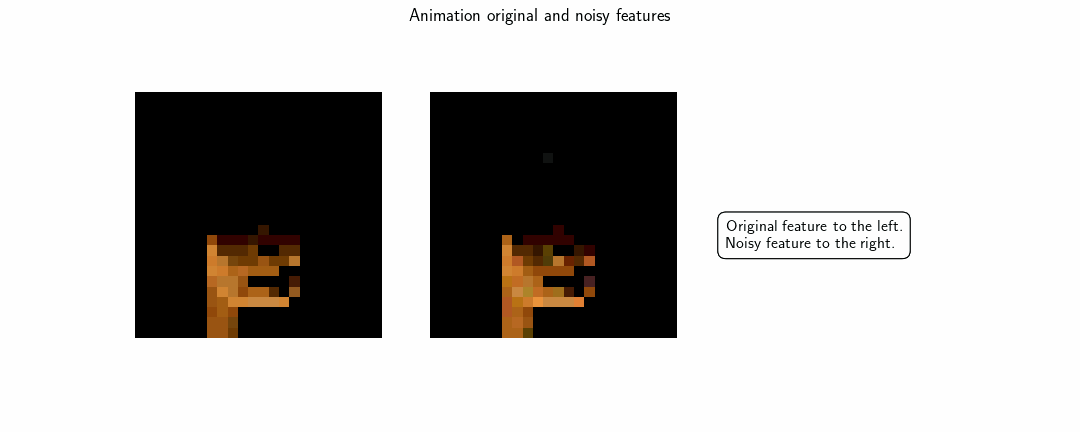

In [31]:
N_plots = 4

noiseless_gif = np.zeros((N_plots, 24, 24, 3))
noisy_gif = np.zeros((N_plots, 24, 24, 3))

noiseless_indices = np.argsort(-np.mean(H_noiseless, axis=1))[:N_plots]
noisy_indices = np.argsort(-np.mean(H_noisy, axis=1))[:N_plots]

for i in range(N_plots):
    noiseless_gif[i] = noiseless_features[:, :, :, noiseless_indices[i]]
    noisy_gif[i] = noisy_features[:, :, :, noisy_indices[i]]

fig, ax = plt.subplots(figsize=(15,6), ncols = 3)
fig.suptitle("Animation original and noisy features ")
def animate(i):
    ax[0].imshow(noiseless_gif[i])
    ax[0].axis("off")

    ax[1].imshow(noisy_gif[i])
    ax[1].axis("off")
    
    text_string =  f"Original feature to the left.\nNoisy feature to the right." 
    ax[2].text(0, 0.4, text_string, size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
    ax[2].axis("off")
anim = animation.FuncAnimation(fig, animate, interval=3000, frames=N_plots)
anim.save('Animations/Comparing noisy and original traits.gif', writer='pillow')
#Displays animation
with open('Animations/Comparing noisy and original traits.gif','rb') as file:
    display(Image(file.read()))
plt.close()

For the features above, we have tried to elect the most prominent features among those previously presented. This was done by calculating the mean of the weights for each feature, and then find the ten features with the highest average weight. From the animation above, one can see that the algorithm generally fails to isolate the features to the same extent as for noiseless images. This is therefore an example of underfitting, and we are now curious to see if we can find a $d$ that minimzes the degree of underfitting, while also avoiding overfitting. 

To do this, we have compared the error after 1000 iterations for different $d$. We have also chosen to do this for several values of the noise coefficient, $\sigma$. This is done because we expect that for greater amounts of noise, one would have to decrease $d$ even further in order to filter out more of the noise, and we want to investigate if this is true. 

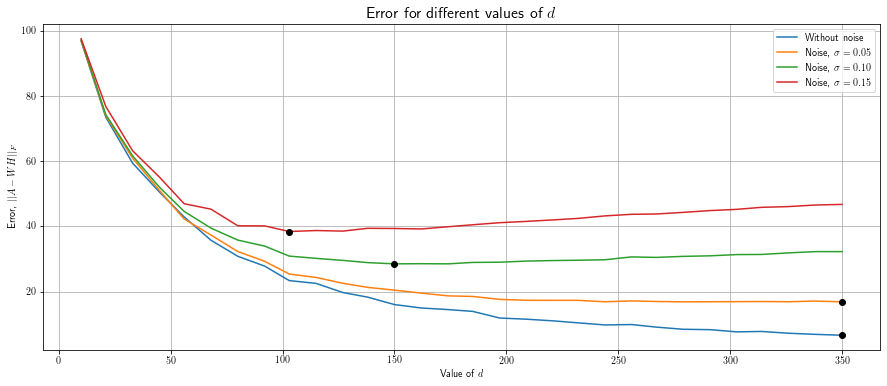

In [34]:
d_array = np.linspace(10, 350, 30, dtype='i2') #Array of d values

error_with_noise_array = np.zeros(len(d_array))
faces_opacity, faces_rgb, faces_reshaped = reshape_images(faces500)
sigma_array = np.linspace(0, 0.15, 4)

plt.figure(figsize=(15,6))
plt.title(r"Error for different values of $d$")

for sigma in sigma_array:
    noisy_faces = add_noise(faces_reshaped, sigma)
    for i in range(len(d_array)):
        W, H, error_estimate = NMF(noisy_faces, d_array[i], 1e-9, 1000, 1)
        error_with_noise_array[i] = np.linalg.norm(faces_reshaped - W @ H, "fro")
    if sigma==0:
        label = "Without noise"
    else:
        label = rf"Noise, $\sigma = {sigma:.2f}$"
    min_index = np.argmin(error_with_noise_array)
    plt.plot(d_array, error_with_noise_array, label=label)
    plt.plot(d_array[min_index], error_with_noise_array[min_index], "o" , color = "black")

plt.xlabel(r"Value of $d$")
plt.ylabel(r"Error, $||A-WH||_F$")
plt.grid()
plt.legend()
plt.savefig("Cryptopunks with noise/Underfitting and overfitting, Error for different values of d.png")
plt.show()

The plot above shows that we no longer have a strictly decreasing curve when we add noise. For the lowest $d$ values, we get "underfitting" as our model simplifies the data too much, which yields a reconstruction with a higher error. We still get a decreasing graph for these values, as increasing the value of $d$ feeds more information to our underfed model.

For higher values of $d$ the error starts to increase. This happens bacause we now manage to capture the less prominent features of the images, which also includes noise. This takes us closer to the cryptopunks with noise, but further away from the original images we actually want to recreate. So even though this gives a better reconstuction of the matrix we fed the algorithm, it is not desirable.

This means that there is an optimal $d$ value for a given noise level, marked with a black dot, and the ideal $d$ is lower for increasing levels of noise. This occurs as we are only able to recapture the most prominent features in the sample, and is unable to catch much of the noise. This $d$ value will lay between the intervals of overfitting and underfitting. 

Throughout this project, we have looked into how NMF can be used in order to compress data and denoise images. Without noise, we had a situation in which we only had to balance the concerns of wanting more accurate reconstructions and actually compressing the data. On the other hand, when we introduced noise, it became evident that the choice of $d$ was no longer that trivial. Here, we saw that in some cases we would choose a too low $d$, resulting in an underfitting of our data, in which we are unable to recreate essential elements. This is because our $W$ and $H$ matrices only can contain a fixed amount of information, and for a low $d$ value this information cap is simply too low. Furthermore, one could risk choosing a too large $d$, in which the model overfits the data, resulting in images polluted by noise. The effect of this is that an increase in $d$, actually also increases the error. This happens because we not only manage to recreate all the important pieces of our sample, we also recreate the inaccuracies of our initial data, which we would preferably avoid in our algorithm. 

In [ ]:
!zip -r "/content/Cryptopunks (without noise).zip" "/content/Cryptopunks (without noise)"
!zip -r "/content/Cryptopunks with noise.zip" "/content/Cryptopunks with noise"
!zip -r "/content/Matrices.zip" "/content/Matrices"
!zip -r "/content/Animations.zip" "/content/Animations"

**Sources**

Rózsa, Pál. (2007). MATHEMATICAL PRELIMINARIES. Applied Dimensional Analysis And Modeling, 1-26. doi: 10.1016/b978-012370620-1.50007-1 (https://www.sciencedirect.com/science/article/pii/B9780123706201500071)

Taboga, Marco (2021). "Matrix product and rank", Lectures on matrix algebra. Retrieved 7 April 2022, from https://www.statlect.com/matrix-algebra/matrix-product-and-rank.

Singular value decomposition - Wikipedia. (2022). Retrieved 7 April 2022, from https://en.wikipedia.org/wiki/Singular_value_decomposition
